## Paired Datasets

In [1]:
import scanpy as sc


In [2]:
scadata = sc.read_text('../data/st/breast cancer pair/brca_scRNA_GEP_subset.txt')

In [6]:
scadata = scadata.T

In [10]:
import pandas as pd

label = pd.read_csv('../data/st/breast cancer pair/brca_scRNA_celllabels_subset.txt',index_col=0,sep='\t')

In [11]:
scadata.obs['cell type'] = label

In [14]:
def scanpypp(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    # sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
    # sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")
    sc.pp.highly_variable_genes(adata,min_mean=0.1,max_mean
    =2,min_disp=0.25)
    sc.pl.highly_variable_genes(adata)
    adata = adata[:,adata.var.highly_variable]
    sc.pp.scale(adata)
    sc.pp.pca(adata, n_comps=50)
    sc.pp.neighbors(adata,n_neighbors=15)
    sc.tl.umap(adata)
    return adata

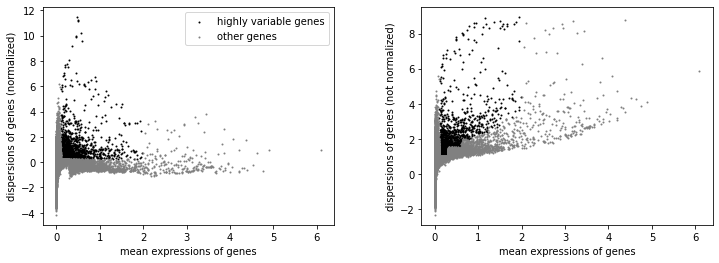

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
scpp = scanpypp(scadata.copy())

In [17]:
sc.settings.set_figure_params(facecolor='white')

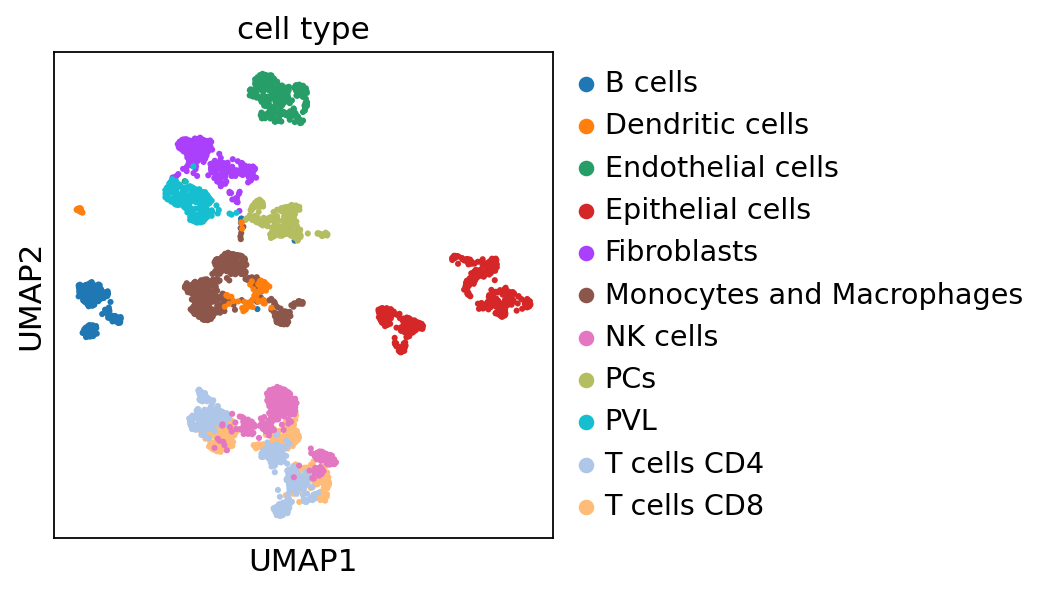

In [18]:
sc.pl.umap(scpp,color=['cell type'])

In [26]:
# scadata.var['feature_types'] = 'Gene Expression'
scadata.obs['batch'] = pd.Categorical(scadata.obs['batch'])

In [27]:
scadata.write_h5ad('../data/st/breast cancer pair/scraw.h5ad')

In [33]:
scpp.uns['pred_colors'] = 'blue'

In [92]:
pred = pd.read_csv('../output/st_brca/1/1/leaf_labels.csv',index_col=0)
scpp.obs['pred'] = pred['Label']

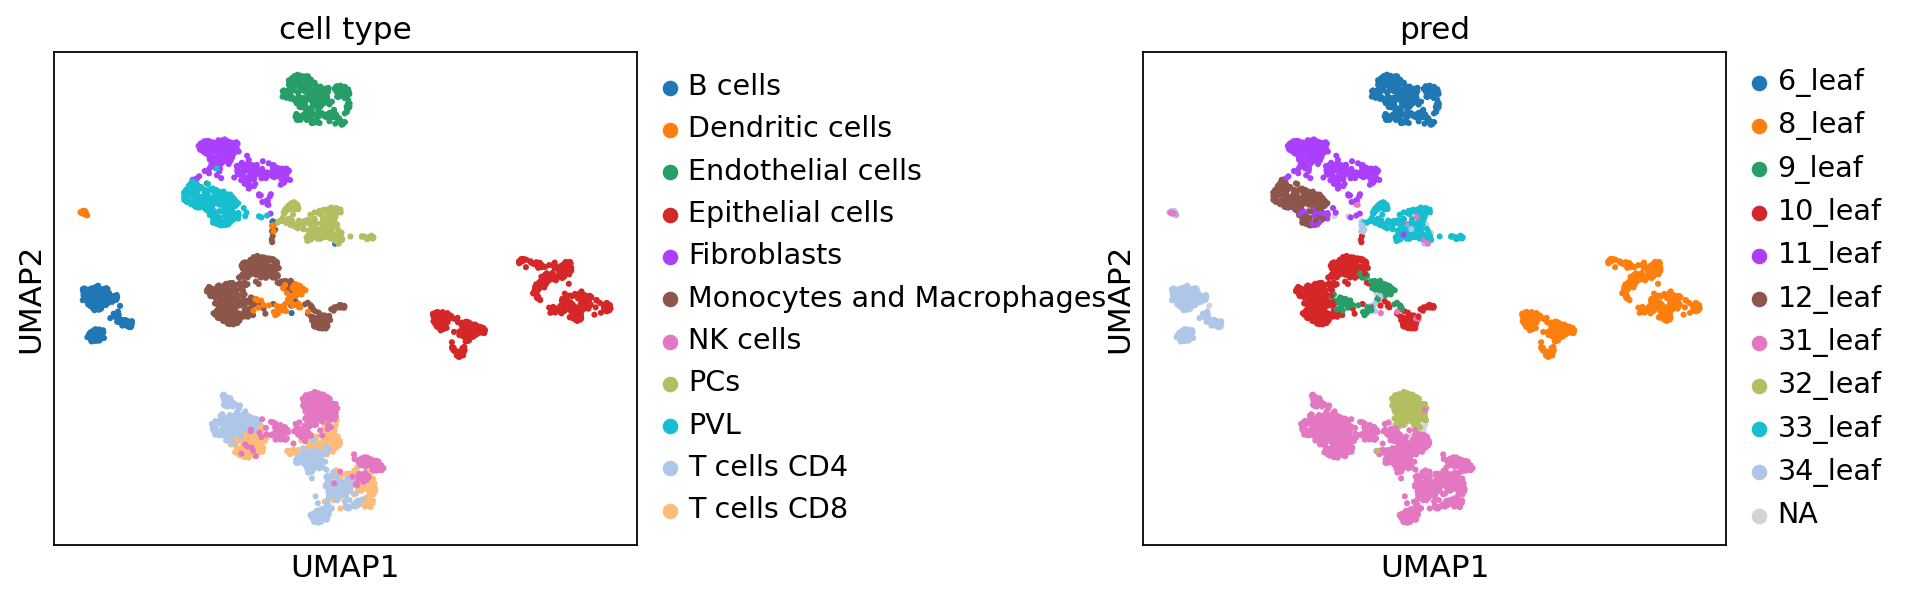

In [93]:
sc.pl.umap(scpp, color=['cell type','pred'],wspace=0.7)

In [237]:
# mapping = pd.read_csv('../output/st_brca/0/mapping.csv',index_col=0) 
# mapping_values = mapping.values.astype(float) 
scpp.obs['embedding'] = None
mapping = pd.read_csv('../output/st_brca/0/embedding.csv',index_col=0) 
# scpp.obsm['embedding'] = embedding

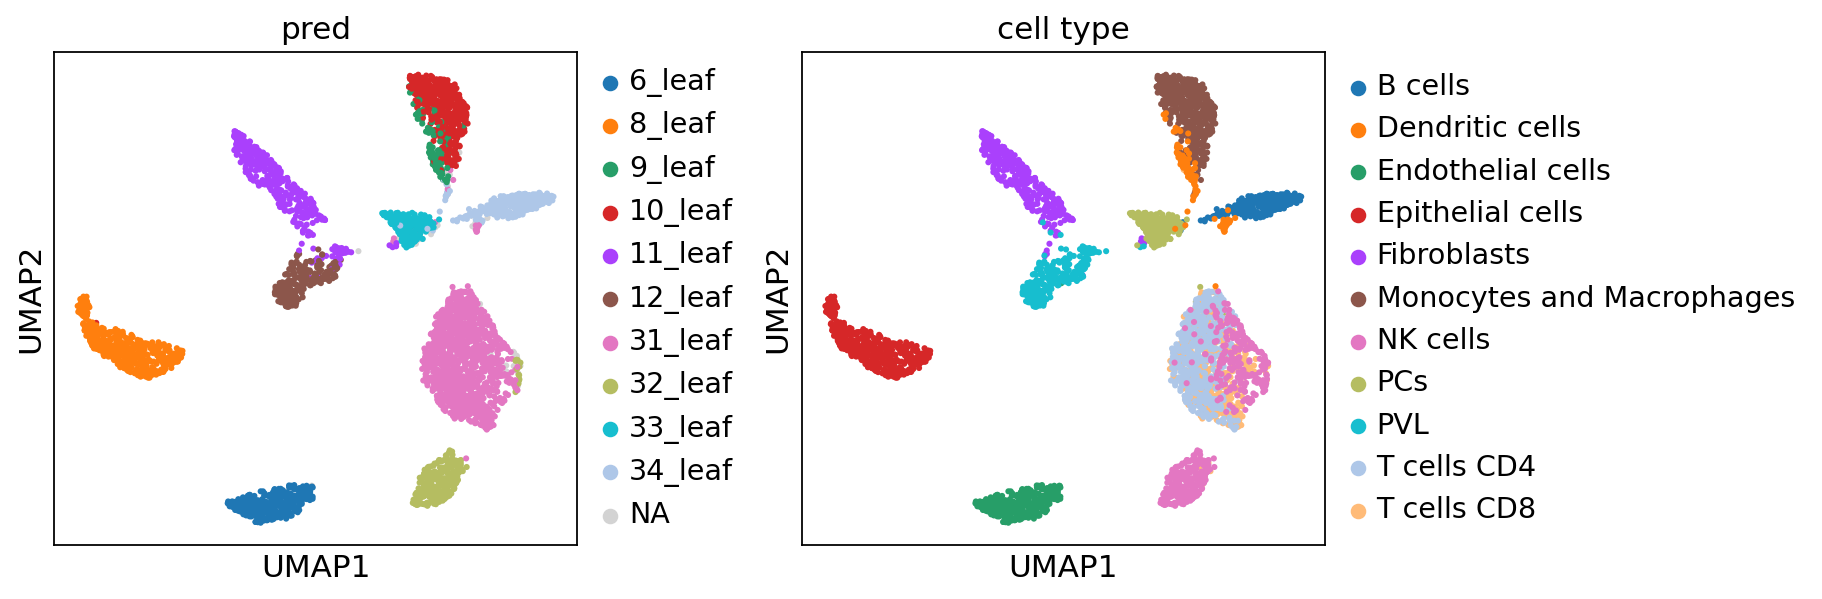

In [235]:
scpp.obsm['embedding'] = scpp.X.dot(mapping)
sc.pp.neighbors(scpp, n_neighbors=20, key_added='lda',use_rep='embedding')
adata_lda = scpp.copy()
sc.tl.umap(adata_lda,neighbors_key='lda')
sc.pl.umap(adata_lda,color=['pred', 'cell type'],wspace=0.3)


In [239]:
mapping.columns = mapping.columns.astype(int)
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# mapping_norm = pd.DataFrame(scaler.fit_transform(mapping), columns=mapping.columns)

In [240]:
mapping_ct = pd.DataFrame(index=mapping.index)
for leaf in scpp.obs['pred'].cat.categories:
    i = int(leaf.split('_')[0])
    k, alpha = i, 1
    ancestorsp, ancestorsn =  [], []
    mapping_ct.loc[:,i] = 0
    # mapping_ct.loc[:,i] = mapping.loc[:,int((k-1)/2)]*((i%2)*2-1)*(-1)*2
    while k > 0:
        if k % 2 == 1:
            ancestorsn.append(int((k-1)/2))
        else:
            ancestorsp.append(int((k-1)/2))
        mapping_ct.loc[:,i] += mapping.loc[:,int((k-1)/2)] * alpha * ((k%2)*2-1) * (-1) 
        # print(i,k,int((k-1)/2),(k%2)*2-1,alpha)
        k = int((k-1)/2)
        alpha = alpha / 8
    # mapping_ct.loc[:,i] =+ mapping.loc[:,ancestorsp].mean(axis=1)
    # mapping_ct.loc[:,i] =- mapping.loc[:,ancestorsn].mean(axis=1)

In [137]:
sum(mapping_ct.loc[:,9]-mapping_ct.loc[:,12])

0.4576848760548269

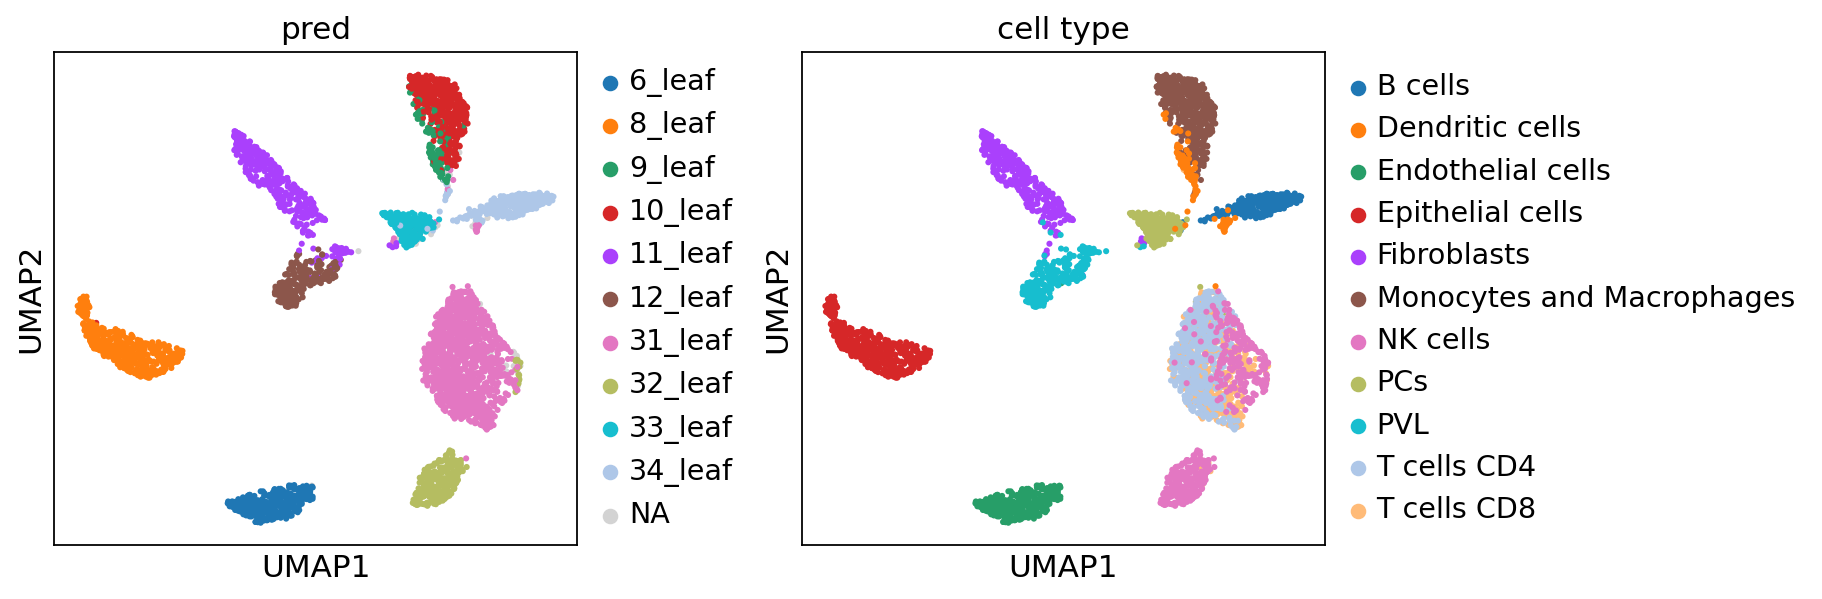

In [149]:
sc.pl.umap(adata_lda,color=['pred', 'cell type'],wspace=0.3)

/home/xinzhu/anaconda3/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


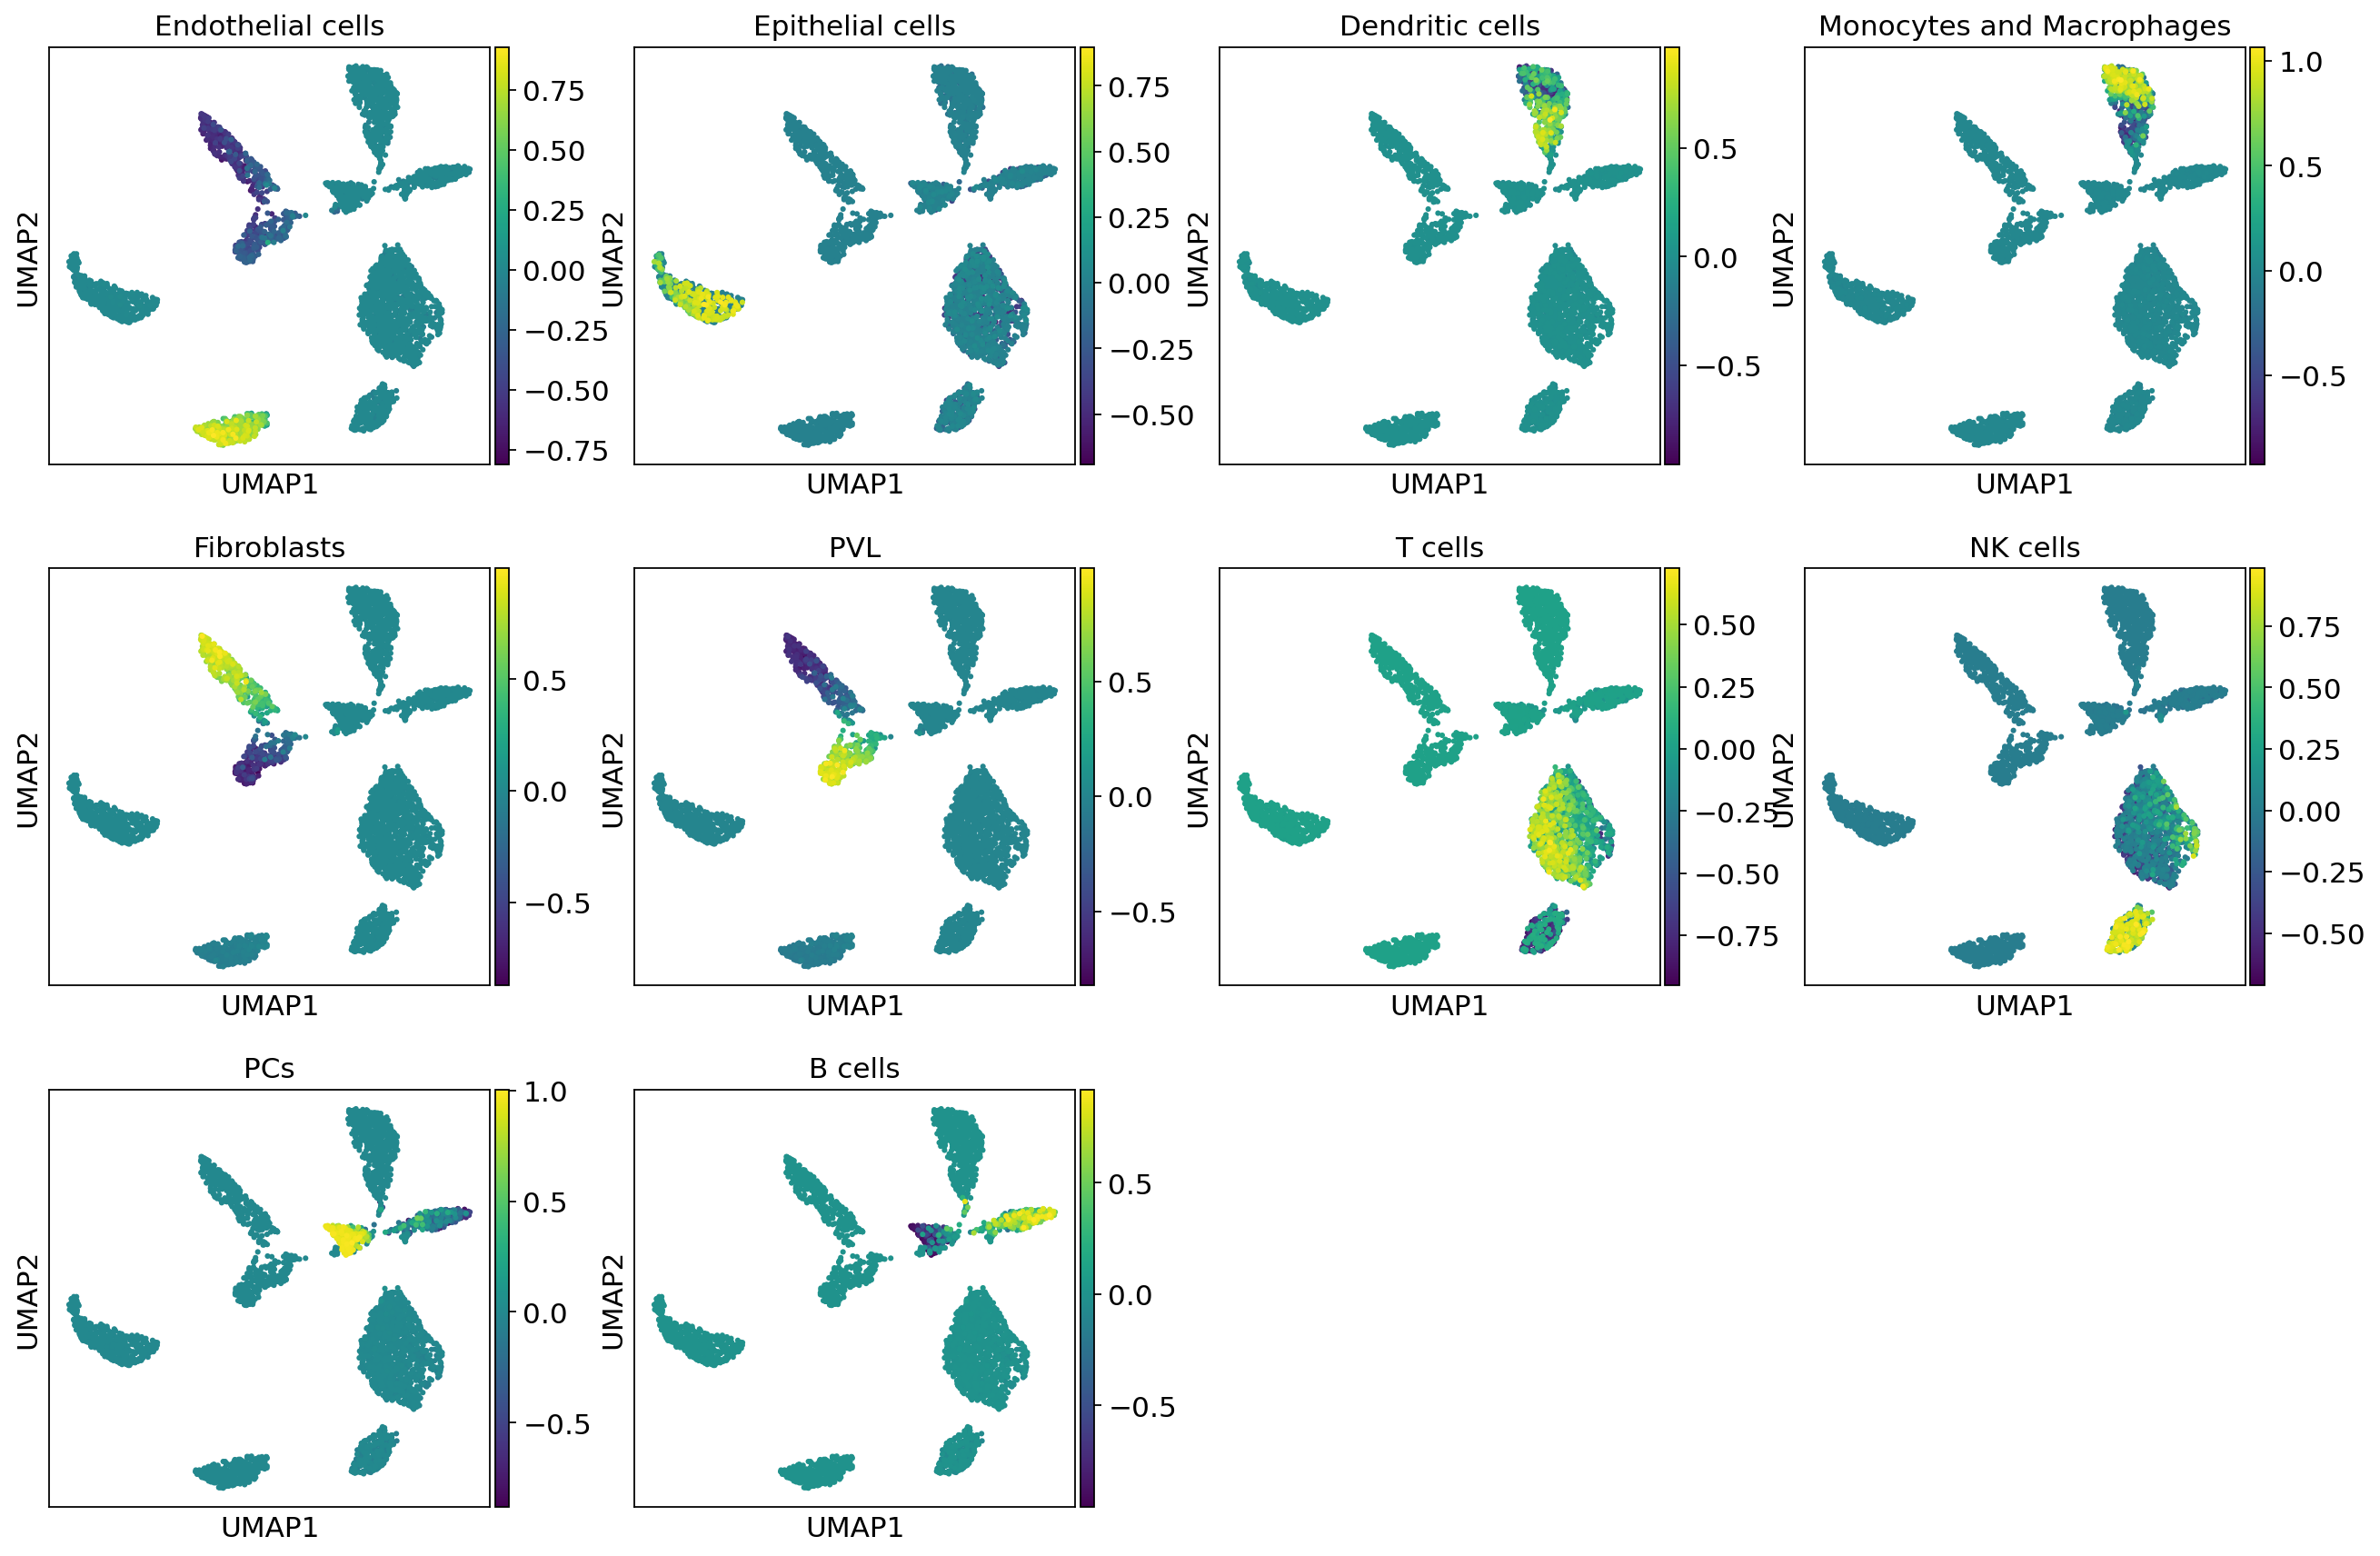

In [241]:
# scpp.obsm['CITEpool celltype score'] = scpp.X.dot(mapping_ct)
adata_score = sc.AnnData(mapping_ct,obs=scpp.obs,obsm=adata_lda.obsm)
# adata_score = sc.AnnData(scpp.X.dot(mapping_ct),obs=scpp.obs,obsm=adata_lda.obsm)
adata_score.var_names = mapping_ct.columns.astype(str)
adata_score.var_names = ['Endothelial cells', 'Epithelial cells', 'Dendritic cells', 'Monocytes and Macrophages',  
       'Fibroblasts', 'PVL', 'T cells', 'NK cells', 'PCs', 'B cells',]
sc.pl.umap(adata_score,color=['Endothelial cells', 'Epithelial cells', 'Dendritic cells', 'Monocytes and Macrophages',  
       'Fibroblasts', 'PVL', 'T cells', 'NK cells', 'PCs', 'B cells',])

In [224]:
straw = sc.read_text('../data/st/breast cancer pair/brca_STdata_GEP.txt').T
coordinate = pd.read_csv('../data/st/breast cancer pair/brca_STdata_coordinates.txt',index_col=0,sep='\t')
coordinate.iloc[:,0] = -coordinate.iloc[:,0] 
straw.obsm['coordinates'] = coordinate.values


In [219]:
sc.pp.log1p(straw)

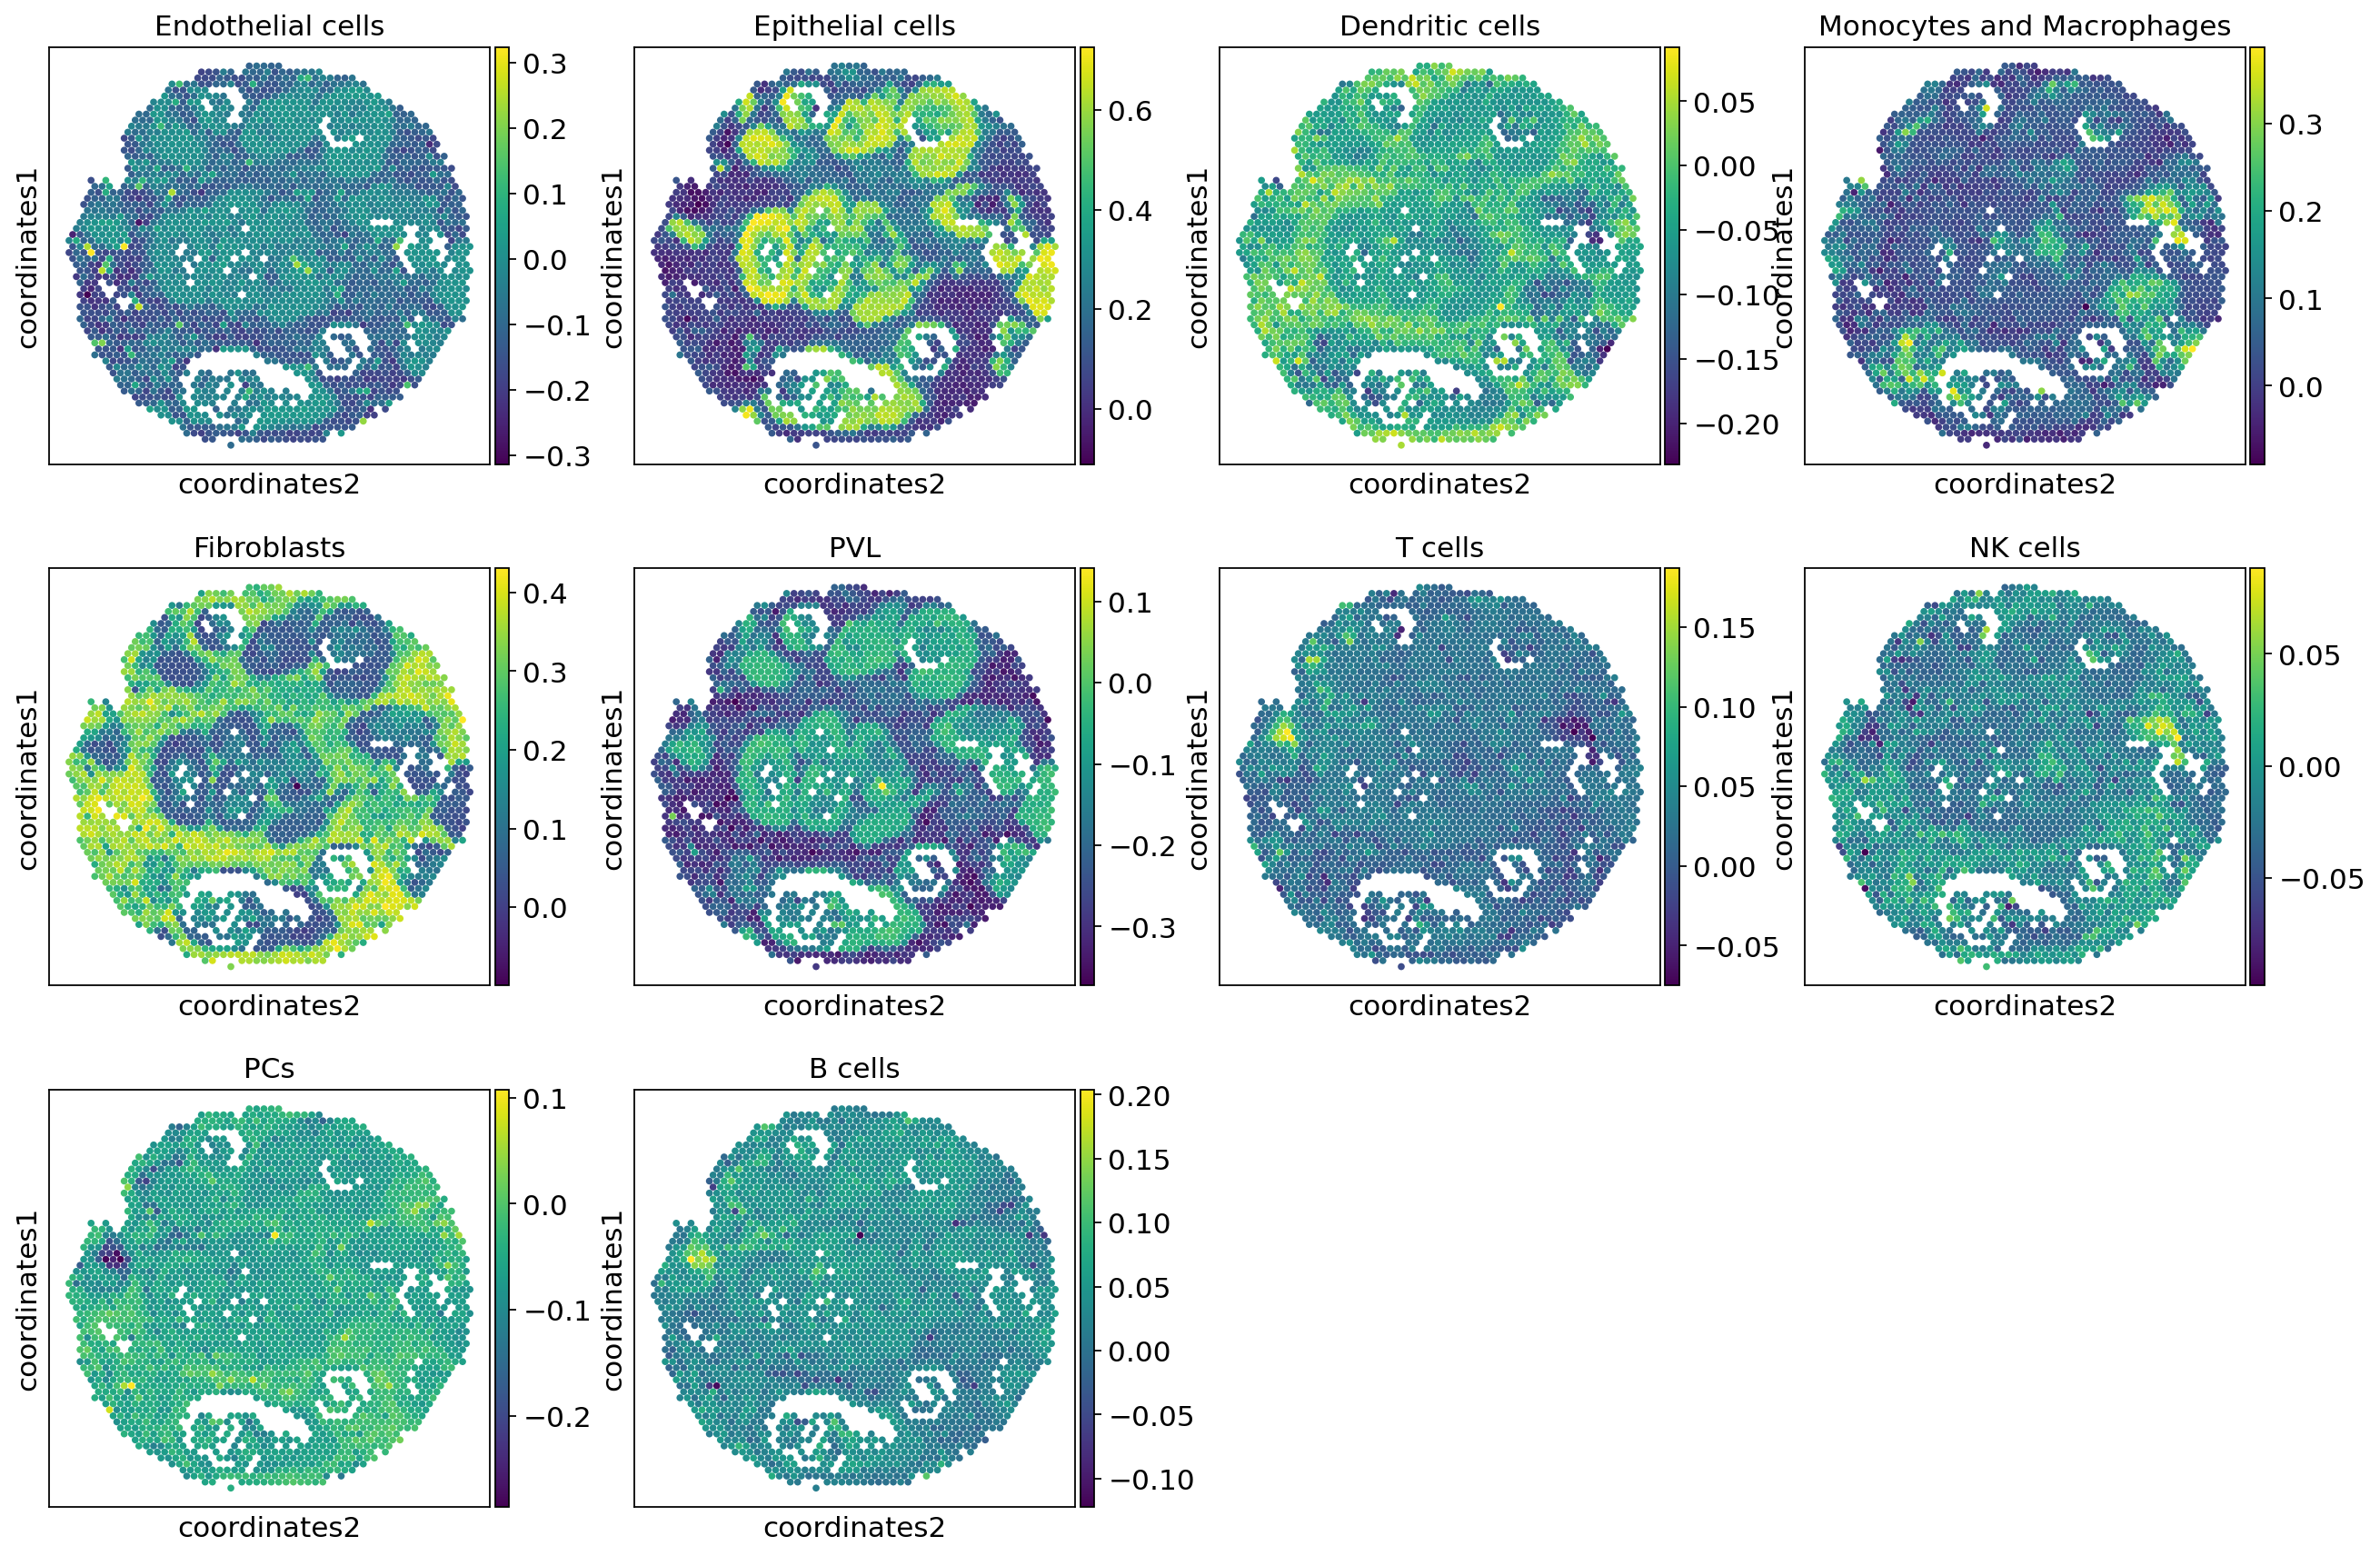

In [230]:
from sklearn.preprocessing import normalize
vars = straw.var_names.intersection(mapping_ct.index)
stmapping = sc.AnnData(normalize(straw[:,vars].X.dot(mapping_ct.loc[vars,:]),norm='l1'),obsm=straw.obsm)
stmapping.var_names = ['Endothelial cells', 'Epithelial cells', 'Dendritic cells', 'Monocytes and Macrophages',  
       'Fibroblasts', 'PVL', 'T cells', 'NK cells', 'PCs', 'B cells',]
sc.pl.embedding(stmapping,basis='coordinates',components=['2,1'],color=['Endothelial cells', 'Epithelial cells', 'Dendritic cells', 'Monocytes and Macrophages',  
       'Fibroblasts', 'PVL', 'T cells', 'NK cells', 'PCs', 'B cells',])


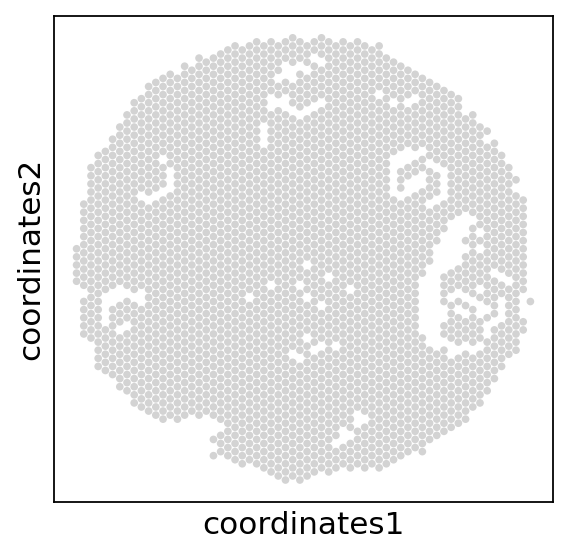

In [201]:
sc.pl.embedding(straw, basis='coordinates')

## Spatial CITE-seq

In [1]:
import scanpy as sc
import pandas as pd


In [54]:
# adt = pd.read_csv('../data/st/stCITEseq/human tonsil/protein.tsv',index_col=0,sep='\t')
adt = pd.read_csv('../data/st/stCITEseq/humanthymus_protein.tsv',index_col=0,sep='\t')

In [55]:
adt.columns = [x.split('.')[0] for x in adt.columns]

In [56]:
import numpy as np
y = np.apply_along_axis(lambda x: np.log(x+1) - np.mean(np.log(x+1)),0,adt)   
x = pd.DataFrame(y, index=adt.index, columns=adt.columns)

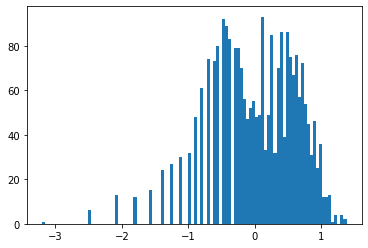

In [70]:
import matplotlib.pyplot as plt

plt.hist(x.loc[:,'CD3'],bins=100)
plt.show()

In [117]:
rna = sc.read_csv('../data/st/stCITEseq/human tonsil/RNA.tsv',delimiter='\t')

In [119]:
rna.obs_names

Index(['29x42', '44x36', '34x6', '42x19', '41x6', '41x39', '49x13', '25x28',
       '12x1', '16x11',
       ...
       '26x48', '31x26', '16x34', '19x34', '37x26', '2x26', '30x26', '23x48',
       '8x44', '5x44'],
      dtype='object', length=2492)

In [107]:
adata = sc.read_h5ad('../data/st/human lymph node/rna_sodb.h5ad')

In [116]:
adata.obs_names

Index(['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1',
       'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1',
       'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1',
       'AAACCGGGTAGGTACC-1',
       ...
       'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1',
       'TTGTTGGCAATGACTG-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=4035)

In [104]:
def scanpy_flow(adata,if_log=True):
    sc.settings.set_figure_params(dpi=80, facecolor='white')
    
    if if_log:
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata,min_disp=0.01)
    adata = adata[:,adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10, zero_center=False)
    # adata.X = preprocessing.scale(adata.X)
    sc.tl.pca(adata, svd_solver='arpack',n_comps=50)
    # sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    return adata

In [106]:
adata_pp = scanpy_flow(adata.copy())

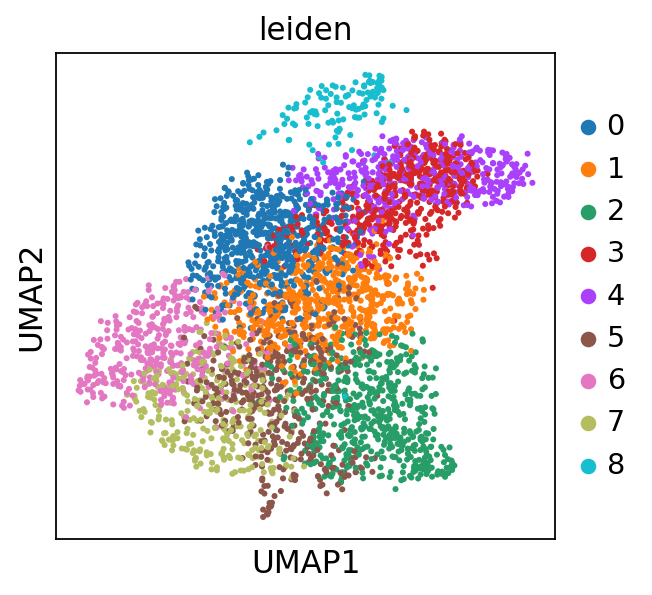

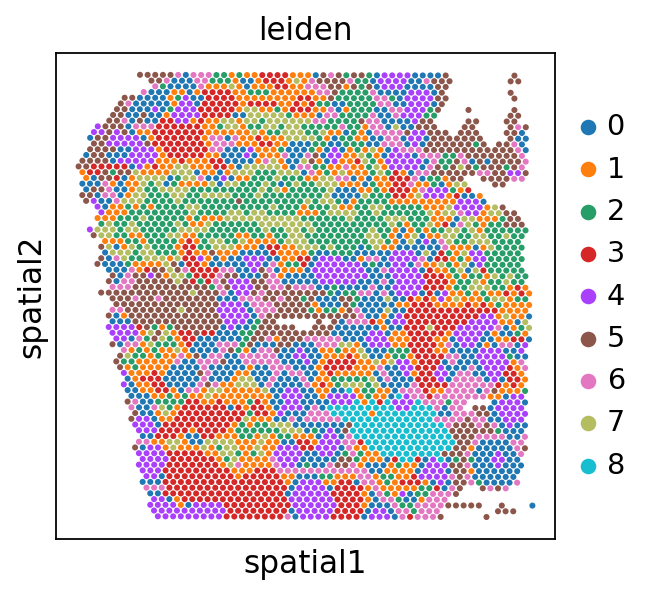

In [111]:
sc.pl.umap(adata,color=['leiden'])
sc.pl.embedding(adata,basis='spatial',color='leiden')

In [115]:
adata.X[:100,200:300].toarray()

array([[0., 0., 0., ..., 7., 3., 0.],
       [0., 0., 0., ..., 3., 1., 0.],
       [0., 0., 1., ..., 7., 0., 0.],
       ...,
       [0., 0., 0., ..., 4., 3., 0.],
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 1., ..., 4., 2., 0.]], dtype=float32)

## Stereo-CITE-seq

In [2]:
import gefpy


In [ ]:
from gefpy import gef_readersub

In [3]:
from gefpy.bgef_reader_cy import BgefR
gef = gefpy("../data/st/huada_mouse_spl/C04776D6.cellbin.gef")

TypeError: 'module' object is not callable